# Host-guest usage with stk

by: Andrew Tarzia

### Update 25/02/24

Installation of py3Dmol using `pip install py3Dmol` is required.

#### Using latest version of `SpinDry` and `stk`.

- Changes in `SpinDry.Molecule` means we now use `spd.Molecule()` not `spd.Molecule.init()`
- `spd.Spinner.get_conformers` should now take `spd.Supramolecule`, which we initialise from components.
- To then access those components, you must do that through the `Supramolecule` interface.
- Finally, we had to change to using the `stk.complex.Guest` interface.
- See https://stk.readthedocs.io/en/stable/_autosummary/stk.host_guest.Complex.html
- See https://github.com/andrewtarzia/SpinDry/blob/main/examples/

# Imports 

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from rdkit import Chem 
from rdkit.Chem import AllChem as rdkit
from collections import defaultdict
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDistGeom
IPythonConsole.ipython_3d = True

import py3Dmol
from IPython.display import Image
import matplotlib.pyplot as plt
import subprocess
import os
import time
import stk
import stko
import spindry as spd
%matplotlib inline

# Some useful functions 

In [2]:
def show_stk_mol(stk_mol):
    data = rdkit.MolToMolBlock(stk_mol.to_rdkit_mol())
    p = py3Dmol.view(
        data=data,
        style={'stick':{'colorscheme':'cyanCarbon'}}, 
        width=400,
        height=400,
    )
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    p.show()

Working:

In [3]:
bb1 = stk.BuildingBlock(
    smiles='O=CC(C=O)C=O',
    functional_groups=[stk.AldehydeFactory()],
)
bb2 = stk.BuildingBlock(
    smiles='O=CC(Cl)(C=O)C=O',
    functional_groups=[stk.AldehydeFactory()],
)
bb3 = stk.BuildingBlock('NCCN', [stk.PrimaryAminoFactory()])
bb4 = stk.BuildingBlock(
    smiles='NCC(Cl)N',
    functional_groups=[stk.PrimaryAminoFactory()],
)
bb5 = stk.BuildingBlock('NCCCCN', [stk.PrimaryAminoFactory()])

cage = stk.ConstructedMolecule(
    topology_graph=stk.cage.FourPlusSix(
        # building_blocks is now a dict, which maps building
        # blocks to the id of the vertices it should be placed
        # on. You can use ranges to specify the ids.
        building_blocks={
            bb1: range(2),
            bb2: (2, 3),
            bb3: 4,
            bb4: 5,
            bb5: range(6, 10),
        },
        optimizer=stk.MCHammer(),
    ),
)

In [4]:
show_stk_mol(cage)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
cage_energy = stko.MMFFEnergy(ignore_inter_interactions=False).get_energy(cage)

In [6]:
print(cage_energy)

2923.2520861618846


In [7]:
stk_guest = stk.BuildingBlock('C1CC=CCC(C1)O')

In [8]:
guest_energy = stko.MMFFEnergy(ignore_inter_interactions=False).get_energy(stk_guest)

In [9]:
print(guest_energy)

48.76120245750583


In [10]:
show_stk_mol(stk_guest)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [11]:
cage = stk.BuildingBlock.init_from_molecule(cage)
cage_atoms = [
    (atom.get_id(), atom.__class__.__name__)
    for atom in cage.get_atoms()
]

# Build stk guest.
guest_atoms = [
    (atom.get_id(), atom.__class__.__name__)
    for atom in stk_guest.get_atoms()
]

host = spd.Molecule(
    atoms=(
        spd.Atom(id=i[0], element_string=i[1])
        for i in cage_atoms
    ),
    bonds=(),
    position_matrix=cage.get_position_matrix(),
)
guest = spd.Molecule(
    atoms=(
        spd.Atom(id=i[0], element_string=i[1])
        for i in guest_atoms
    ),
    bonds=(),
    position_matrix=stk_guest.get_position_matrix(),
)

In [12]:
host

<Molecule(104 atoms) at 123778176827152>

In [13]:
guest

<Molecule(20 atoms) at 123778165260176>

In [14]:
cg = spd.Spinner(
    step_size=0.5,
    rotation_step_size=5,
    num_conformers=100,
    max_attempts=10000,
)

In [15]:
cg

In [16]:
supramolecule = spd.SupraMolecule.init_from_components(components=(host, guest))

In [18]:
binding_energies = {}

for conformer in cg.get_conformers(supramolecule):
    print(conformer)
    print(conformer.get_cid(), conformer.get_potential())
    for i, comp in enumerate(list(conformer.get_components())):
        if i == 0:
            cage = cage.with_position_matrix(comp.get_position_matrix())
        elif i == 1:
            bound_guest = stk_guest.with_position_matrix(comp.get_position_matrix())
            
    complex_mol = stk.ConstructedMolecule(
        topology_graph=stk.host_guest.Complex(host=cage, guests=stk.host_guest.Guest(bound_guest))
    )
    complex_mol.write(
        f'hg_example_output/conf_{conformer.get_cid()}.mol'
    )
    bound_energy = stko.MMFFEnergy(ignore_inter_interactions=False).get_energy(complex_mol)
    binding_energy = bound_energy - (cage_energy + guest_energy)
    binding_energies[conformer.get_cid()] = binding_energy

SupraMolecule(2 components, <Molecule(104 atoms) at 123778176827152>, <Molecule(20 atoms) at 123778165260176>)
0 -10.154907476240936
SupraMolecule(2 components, <Molecule(104 atoms) at 123778176827152>, <Molecule(20 atoms) at 123778125218384>)
1 -10.532334326710696
SupraMolecule(2 components, <Molecule(104 atoms) at 123778176827152>, <Molecule(20 atoms) at 123778125270672>)
2 -11.665500902879728
SupraMolecule(2 components, <Molecule(104 atoms) at 123778176827152>, <Molecule(20 atoms) at 123778124990992>)
3 -14.735447582015139
SupraMolecule(2 components, <Molecule(104 atoms) at 123778176827152>, <Molecule(20 atoms) at 123778124970576>)
4 -14.229560781859185
SupraMolecule(2 components, <Molecule(104 atoms) at 123778176827152>, <Molecule(20 atoms) at 123778125003600>)
5 -15.47788255403472
SupraMolecule(2 components, <Molecule(104 atoms) at 123778176827152>, <Molecule(20 atoms) at 123778125271696>)
6 -14.595367432349384
SupraMolecule(2 components, <Molecule(104 atoms) at 123778176827152>, 

In [19]:
print(binding_energies)

{0: 395.5225339441672, 1: 157.9369361907775, 2: 684.8550926803982, 3: 201.90225041905978, 4: 70.23016208992976, 5: 6.479719154862323, 6: 14.201990308003587, 7: 41.41587711194279, 8: 38.61547341275582, 9: 23.1107377309977, 10: 55.69605143004355, 11: 49.09235265808502, 12: 361.0950922293082, 13: 153.98969536696995, 14: 121.84832262428517, 15: 25.45092309861093, 16: 26.60297458846435, 17: 32.231575084403175, 18: 43.39062128671503, 19: 110.11106899387687, 20: 156.14551221387865, 21: 190.71952780905212, 22: 172.52848031557915, 23: 238.7598660651911, 24: 254.234626606049, 25: 253.5219899983981}


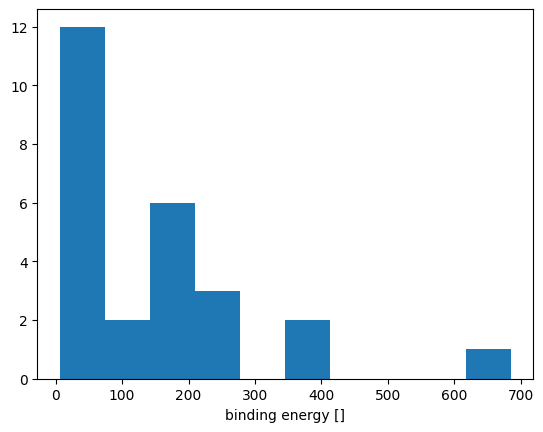

In [20]:
plt.hist([binding_energies[i] for i in binding_energies])
plt.xlabel('binding energy []')
plt.show()